This notebook explores looking at the connectivity and memory requirements for Nengo models

In [1]:
%matplotlib inline
import pylab
import seaborn
import numpy as np
import pandas

import netlist
reload(netlist)
import pprint


/home/tcstewar/env/work/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


We start with a simple model of semantic association, which is often identified as one of the most difficult structures in Spaun.  Initially, we'll look at a 1-Dimensional version (just so we can visualize it), but then we'll scale up to 512 dimensions.

{'memory': 1921, 'messages': 59, 'neurons': 950, 'values': 39}


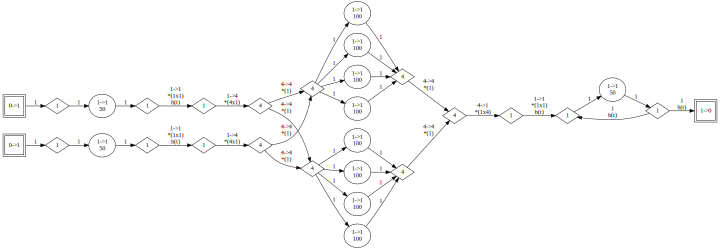

In [44]:
import ctn_benchmark.spa.memory
model = ctn_benchmark.spa.memory.SemanticMemory().make_model(D=1)

# extract the graph from a nengo model.  This returns:
#   ensembles    (groups of x->A->y neurons)
#   nodes        (non-neural components used for organization)
#   connections  (edges)
e, n, c = netlist.compute_graph(model)

# compute some basic stats
pprint.pprint(netlist.calc_stats(e, n, c))

# draw the graph
netlist.plot_graph(e, n, c, size=(10,10))

This graph shows the raw structure of a Nengo model.  

Groups of neurons are shown as circles.  They are labeled with the dimensionality of their inputs (x) and outputs (y), along with the number of neurons.  So each of the groups have 1-dimensional input and 1-dimensional output (```1->1```).  The ones in the middle have 100 neurons each, and the ones on the left and right have 50 neurons each.

Inputs and outputs to and from the model are marked as double-outlined squares.

The diamonds are intermediate values that are generally useful during the design stage, but may be compiled out by the hardware, depending on the situation.  We can think of them as just storage for a vector, rather than directly connecting from one group of neurons to the next.  Sometimes these are completely useless artifacts of how the programmer happened to design the model.  For example, the diamond ```1```s on either side of the ```1->1 / 50``` ensembles do absolutely nothing, just passing their values along.  We can think of this as something like the network ```w->x->A->y->z```, where ```w``` is the same size as ```x``` and is connected to it with an identity matrix (and same for ```y``` and ```z```).  However, sometimes these are conceptually useful, and can have impact on message routing.  For example, consider the diamond ```4```s on either side of the column of neurons in the middle of the graph.  These aggregate 4 separate values (the inputs/outputs from four 1-dimensional groups of neurons) into a single vector.  We can now make connections into and out of that grouped vector, rather than making multiple connections into and out of the individual groups.

Finally, we have the connections (edges) themselves.  There are two types of connections being shown here.  The simple message-passing edges are just labeled with a single number indicating the dimensionality of the message.  The other type of edge also multiplies the message before sending it.  This multiplication can either be by a matrix (indicated as ```*(m,n)```) or by a scalar (indicated as ```*(1)```).   There also may be a low-pass filter, indicates as ```h(t)```.



While this is the default Nengo representation, it's not quite what we want here.  We can also transform this graph slightly to make all the edges just simple message-passing, and introduce a new type of component that just does some multiplications (and maybe a filter) on its inputs.  This is done below, indicated by a square.  Inside the square we indicate the dimensionality of the input and output, the number of multiplies that must be performed total, and the number of low-pass filters applied (if any).

{'memory_d': 950,
 'memory_e': 950,
 'memory_m': 21,
 'messages': 62,
 'n_neurons': 950,
 'n_values': 51}


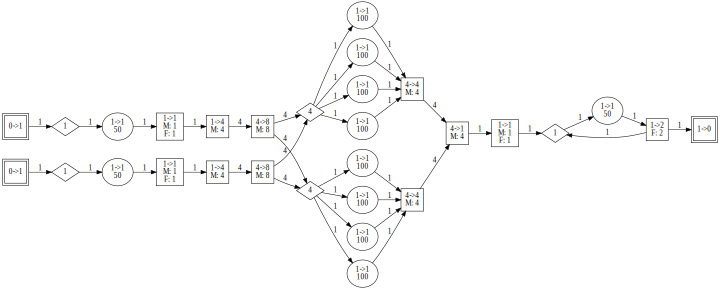

In [3]:
import ctn_benchmark.spa.memory
model = ctn_benchmark.spa.memory.SemanticMemory().make_model(D=1)

e, n, c = netlist.compute_graph(model)
netlist.simplify_conns(e, n, c)
pprint.pprint(netlist.calc_stats(e, n, c))

netlist.plot_graph(e, n, c, size=(10,10))

This sort of reorganizing can be thought of as a sort of compilier optimization.  Making changes like this won't affect the behaviour of the model, ubt may make it more (or less) efficient in terms of the hardware.   Some optimizations are very obvious: for example, in the above graph, after the first group of neurons in the top left, we have three boxes, each of which perform matrix multiplications.  All of these can get merged together into one matrix, just by multiplying those matrices together.  

In fact, they could even get rolled all the way back into the decoder for the neural group itself!  That is, instead of doing ```x->A->y->p->q->r``` as it is now, we coule instead multiply all those matrices together and get ```x->A->r``` directly.  (Note that even though there's a filter on the first box, we can move that filter to the end without changing anything, because low-pass filters are linear).

So, this sort of optimization can be interesting, and so far we've seen it to be very hardware-specific.

The above graph is for a semantic memory of size 1 (i.e. it stores associated 1-dimensional vectors).  For human-level cognitive tasks, we need somewhere around 512-dimensional vectors.  Let's see how the memory requirements scale with size:

In [53]:
import ctn_benchmark.spa.memory

stats = []
Ds = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
for D in Ds:
    model = ctn_benchmark.spa.memory.SemanticMemory().make_model(D=D)

    e, n, c = netlist.compute_graph(model)
    netlist.simplify_conns(e, n, c)
    s = netlist.calc_stats(e, n, c)
    s['D'] = D
    stats.append(s)


In [54]:
df = pandas.DataFrame(stats)
df

,D,memory,messages,neurons,values
0,1,1921,62,950,51
1,2,4466,124,1900,102
2,4,9798,200,3000,164
3,8,27878,352,5200,288
4,16,93702,656,9600,536
5,32,231520,9520,18400,9288
6,64,479712,19024,36000,18568
7,128,1080544,41048,71200,40144
8,256,2355936,85096,141600,83296
9,512,5496544,182408,282400,178816


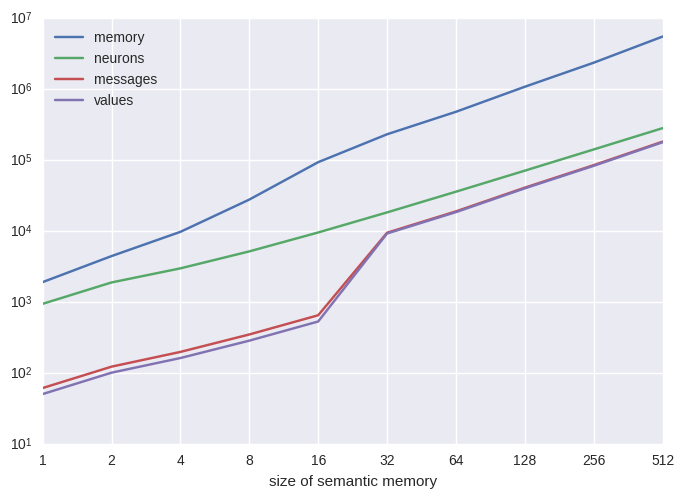

In [55]:
pylab.semilogy(df['memory'], label='memory')
pylab.semilogy(df['neurons'], label='neurons')
pylab.semilogy(df['messages'], label='messages')
pylab.semilogy(df['values'], label='values')
pylab.xticks(np.arange(len(Ds)), Ds)
pylab.legend(loc='best')
pylab.xlabel('size of semantic memory')
pylab.show()


We can also take a look at the distribution of the ensembles in the network.  For this network, we have a very regular structure.

In [100]:
model = ctn_benchmark.spa.memory.SemanticMemory().make_model(D=512)
e, n, c = netlist.compute_graph(model)

ens = {}
for ee in e.values():
    key = (ee['size_in'], ee['n_neurons'], ee['size_out'])
    ens[key] = ens.get(key, 0) + 1
pprint.pprint(ens)

{(1, 100, 1): 2056, (16, 800, 16): 96}


That is, we have 2056 groups of neurons that are 1 input, 100 neurons, and 1 output, and then we have 96 groups that have 16 inputs, 800 neurons, and 16 outputs.

Now let's try this with a different model.  Here is the Basal Ganglia model that was benchmarked in the SpiNNaker paper.

{'memory': 59607, 'messages': 453, 'neurons': 4350, 'values': 386}


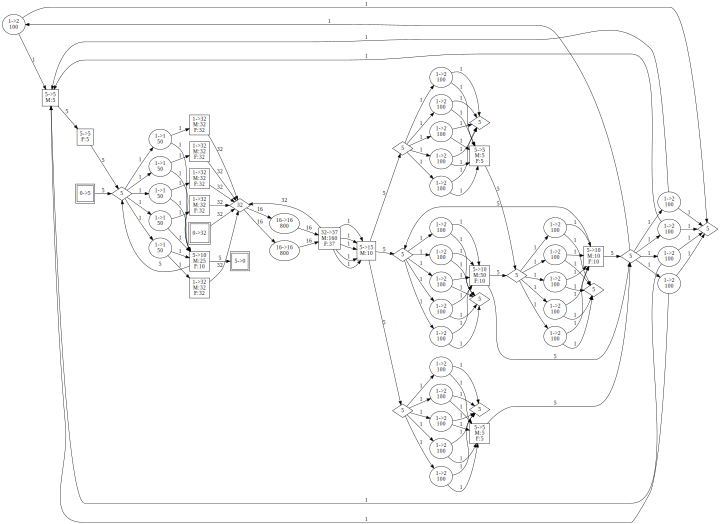

In [56]:
model = ctn_benchmark.nengo.SPASequence().make_model(n_actions=5)
e, n, c = netlist.compute_graph(model)
netlist.simplify_conns(e, n, c)
pprint.pprint(netlist.calc_stats(e, n, c))

netlist.plot_graph(e, n, c, size=(10,10))

In [60]:
import ctn_benchmark.spa.memory

stats = []
actions = [5, 10, 20, 50, 100, 200]
for n_actions in actions:
    model = ctn_benchmark.nengo.SPASequence().make_model(n_actions=n_actions, D=512)
    e, n, c = netlist.compute_graph(model)
    netlist.simplify_conns(e, n, c)
    s = netlist.calc_stats(e, n, c)
    s['n_actions'] = n_actions
    stats.append(s)

In [61]:
df = pandas.DataFrame(stats)
df

,memory,messages,n_actions,neurons,values
0,832407,4773,5,28350,4226
1,845757,7498,10,31100,6916
2,872907,12948,20,36600,12296
3,957957,29298,50,53100,28436
4,1111707,56548,100,80600,55336
5,1464207,111048,200,135600,109136


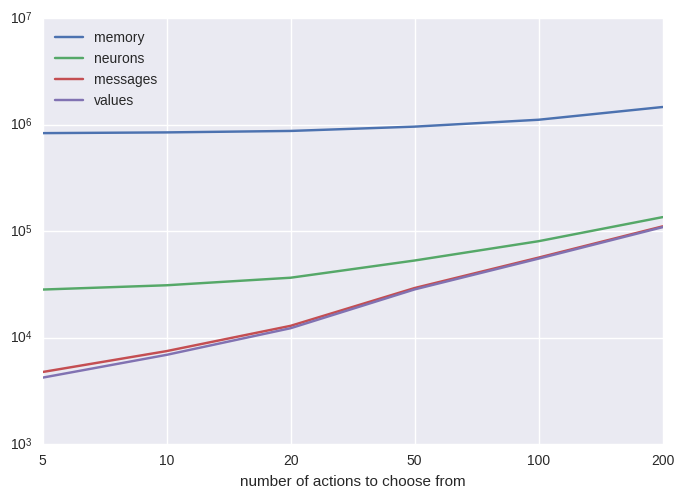

In [64]:
pylab.semilogy(df['memory'], label='memory')
pylab.semilogy(df['neurons'], label='neurons')
pylab.semilogy(df['messages'], label='messages')
pylab.semilogy(df['values'], label='values')
pylab.xticks(np.arange(len(actions)), actions)
pylab.legend(loc='best')
pylab.xlabel('number of actions to choose from')
pylab.show()


In [102]:
model = model = ctn_benchmark.nengo.SPASequence().make_model(n_actions=200, D=512)
e, n, c = netlist.compute_graph(model)

ens = {}
for ee in e.values():
    key = (ee['size_in'], ee['n_neurons'], ee['size_out'])
    ens[key] = ens.get(key, 0) + 1
pprint.pprint(ens)

{(1, 50, 1): 200, (1, 100, 2): 1000, (16, 800, 16): 32}


Here, we have 200 groups that are 1->50->1, 1000 groups that are 1->100->2, and 32 that are 18->800->16.

Now let's take a look at this for Spaun!  I've pre-computed the netlist for this, as it's huge.  And it's also so huge that we're not going to try to plot the actual diagram.

In [87]:
import shelve
db = shelve.open('spaun_netlist')
e = db['e']
n = db['n']
c = db['c']
db.close()

But, we can compute the stats on it.

In [88]:
netlist.calc_stats(e, n, c)

{'memory': 30455151, 'messages': 535172, 'neurons': 4311350, 'values': 3255050}

This is a much smaller memory requirement than we'd quoted before! (down to 30M from 400M).  What happened here?

One possibility is that there's a bug in my code for extracting the netlist, and I'm looking into that.  But there have also been a lot of changes to Spaun since we last measured this number.  In particular, it looks like it's using a lot more smaller ensembles.  This is specific to this particular version of Spaun (and this particular model).  I'm looking into grabbing a few more largish models to see if I can get a wider variety of components.

However, in the meantime, we can look at the sizes of the neuron groups in Spaun:

In [99]:
ens = {}
for ee in e.values():
    key = (ee['size_in'], ee['n_neurons'], ee['size_out'])
    ens[key] = ens.get(key, 0) + 1
pprint.pprint(ens)

{(1, 20, 0): 7,
 (1, 25, 2): 24,
 (1, 40, 0): 9,
 (1, 50, 0): 83,
 (1, 50, 1): 61552,
 (1, 50, 2): 3004,
 (1, 50, 3): 30,
 (1, 75, 2): 8224,
 (1, 100, 0): 2,
 (1, 100, 1): 803,
 (1, 100, 2): 1194,
 (1, 150, 1): 1,
 (1, 150, 2): 2,
 (1, 200, 0): 1,
 (1, 200, 1): 1,
 (1, 500, 0): 1,
 (1, 500, 1): 50,
 (2, 150, 2): 1,
 (2, 150, 4): 1024,
 (2, 9000, 3): 6,
 (3, 5000, 3): 1,
 (6, 7000, 3): 2,
 (6, 7000, 6): 1}


The giant ensembles at the bottom are the new motor system, which they've apparantly increased to be larger than I thought they'd done.  But other than that, it's all 1-D and 2-D ensembles!  So that might help with the mapping for Spaun in particular, but our other models still do require larger 16-D ensembles.

(Note: the ensembles with 0 outputs are ones that could get compiled out....)